## Import Modul

In [ ]:
import pandas as pd  
import numpy as np
import time
import os

from google_play_scraper import app, Sort, reviews

import matplotlib.pyplot as plt 
import seaborn as sns  
import re  
import string  
import emoji

import csv
import requests
from io import StringIO

import nltk  
nltk.download('punkt')  
nltk.download('stopwords')  

from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  

from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import tensorflow
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import random
import os

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

### Scraping data ulasan aplikasi CamScanner

In [ ]:
def scrape_reviews(count):
    app_id = 'com.duolingo'
    country = 'id'  
    language = 'id'  
    
    print(f"Memulai scraping ulasan")
    
    all_reviews = []
    continuation_token = None
    batch_size = 1000  # Jumlah ulasan per request
    
    # Fungsi untuk memproses ulasan
    def process_reviews(reviews):
        processed = []
        for r in reviews:
            processed.append({
                'review_id': r['reviewId'],
                'username': r['userName'],
                'rating': r['score'],
                'date': r['at'].strftime('%Y-%m-%d %H:%M:%S'),
                'content': r['content']
            })
        return processed
    
    while len(all_reviews) < count:
        try:
            # Mengambil ulasan
            result, continuation_token = reviews(
                app_id,
                lang=language,
                country=country,
                sort=Sort.MOST_RELEVANT,
                count=batch_size,
                continuation_token=continuation_token
            )
            
            # Memproses ulasan
            batch_processed = process_reviews(result)
            all_reviews.extend(batch_processed)
            
            print(f"Berhasil mengambil {len(batch_processed)} ulasan. Total: {len(all_reviews)}")
            
            # Jika tidak ada token lanjutan, hentikan loop
            if continuation_token is None:
                print("Tidak ada ulasan lagi yang tersedia.")
                break
                
            # Jeda untuk menghindari rate limiting
            time.sleep(3)
            
        except Exception as e:
            print(f"Error: {str(e)}")
            print("Menunggu 10 detik sebelum mencoba lagi.")
            time.sleep(10)
    
    # Membuat DataFrame
    df = pd.DataFrame(all_reviews)
    
    print(f"\nScraping selesai! Total ulasan yang didapat: {len(df)}")
    
    return df

In [662]:
reviews_df = scrape_reviews(count=15000)

Memulai scraping ulasan
Berhasil mengambil 1000 ulasan. Total: 1000
Berhasil mengambil 1000 ulasan. Total: 2000
Berhasil mengambil 1000 ulasan. Total: 3000
Berhasil mengambil 1000 ulasan. Total: 4000
Berhasil mengambil 1000 ulasan. Total: 5000
Berhasil mengambil 1000 ulasan. Total: 6000
Berhasil mengambil 1000 ulasan. Total: 7000
Berhasil mengambil 1000 ulasan. Total: 8000
Berhasil mengambil 1000 ulasan. Total: 9000
Berhasil mengambil 1000 ulasan. Total: 10000
Berhasil mengambil 1000 ulasan. Total: 11000
Berhasil mengambil 1000 ulasan. Total: 12000
Berhasil mengambil 1000 ulasan. Total: 13000
Berhasil mengambil 1000 ulasan. Total: 14000
Berhasil mengambil 1000 ulasan. Total: 15000

Scraping selesai! Total ulasan yang didapat: 15000


In [663]:
reviews_df.head(5)

,review_id,username,rating,date,content
0,0e5259f4-055a-4548-bc33-75d53b7977fc,Kebasen Jos,3,2025-04-10 12:58:00,apk ini sangat bagus dan membantu untuk belaja...
1,e2f54c77-0551-43e5-aab7-60f5cb953713,Andara Putri,4,2025-04-04 05:46:54,untuk aplikasi nya seruu dan muda untuk di pah...
2,798d3a62-9737-4161-95ef-d5d14155fcc7,Ilyas Al Rizki Muharom,1,2025-03-29 17:50:52,"Untuk aplikasi nya sangat bagus, metode pelaja..."
3,d140767b-1c9a-41e6-8612-9b697fbf3e01,Fransiska Langoday,5,2025-03-23 20:31:14,sebelumnya cukup sulit untuk mengumpulkan 5 He...
4,558f02c7-4fa5-4086-b70d-4513b23bc989,Nur Fuadatul,3,2025-04-05 12:42:35,"Duolingo memang baguss polll, aku suka banget...."


### Ukuran data

In [664]:
reviews_df.shape

(15000, 5)

### Tipe data tiap kolom

In [665]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  15000 non-null  object
 1   username   15000 non-null  object
 2   rating     15000 non-null  int64 
 3   date       15000 non-null  object
 4   content    15000 non-null  object
dtypes: int64(1), object(4)
memory usage: 586.1+ KB


### Missing value

In [666]:
reviews_df.isna().sum()

review_id    0
username     0
rating       0
date         0
content      0
dtype: int64

In [299]:
reviews_df.dropna(subset=['content'], inplace=True)

### Duplikasi data

In [667]:
reviews_df.duplicated().sum()

0

## Preprocessing

### Cleaning text

In [300]:
def cleaningText(text):
    # Menghapus username/mentions
    text = re.sub(r'@\w+', '', text)

    # Menghapus tag
    text = re.sub(r'#\w+', '', text)

    # Menghapus teks dalam []
    text = re.sub(r'\[\w+]', '', text)

    # Menghapus karakter non-alfanumerik
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\b\w+(?:com|org)\b', '', text)

    # Menghapus karakter numerik
    text = re.sub(r'\d+', '', text)

    # Menyeragamkan ke lower case (case folding)
    text = text.lower()

    # Menghapus whitespace (spasi ganda, tab, newline)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')

    #  Menghapus tanda baca (seperti titik, koma, tanda seru, tanda tanya, dan titik koma)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Menghapus emoji
    text = emoji.replace_emoji(text, replace='')
    
    return text

In [17]:
# slang words
# kamus 1
sl1 = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

# kamus 2
sl2 = pd.read_csv("https://raw.githubusercontent.com/haryoa/indo-collex/main/dict/inforformal-formal-Indonesian-dictionary.tsv", sep="\t")
sl2.set_index("informal", drop=True, inplace=True)
sl2 = sl2.to_dict()["formal"]
sl2

# kamus 3
sl3 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep="\t", header=None)
sl3.set_index(0, drop=True, inplace=True)
sl3 = sl3.to_dict()[1]

# Gabungkan semua kamus slang words
sl_words = {**sl1, **sl2, **sl3}

In [18]:
# stopwords
# kamus 1: sastrawi
factory = StopWordRemoverFactory()
sw_id1 = factory.get_stop_words()

# kamus 2
sw_id2 = pd.read_csv("https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt",header=None)
sw_id2 = list(sw_id1[0])

# kamus 3
sw_id3 = ['kalau', 'terus']

# kamus 4: NLTK
sw_id4 = set(stopwords.words('indonesian'))

# Gabungkan
sw_id = sw_id1 + sw_id2 + sw_id3 + list(sw_id4)

In [19]:
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    filtered = []
    for txt in text:
        if txt not in sw_id:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in sl_words:
            fixed_words.append(sl_words[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [668]:
clean_df = reviews_df.copy()

# Membersihkan teks
clean_df['clean_content'] = clean_df.content.apply(cleaningText)

# Mengganti kata-kata slang dengan kata-kata standar 
clean_df.clean_content = clean_df.clean_content.apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata)
clean_df.clean_content = clean_df.clean_content.apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum)
clean_df.clean_content = clean_df.clean_content.apply(filteringText)

# Menggabungkan token-token menjadi kalimat 
clean_df.clean_content = clean_df.clean_content.apply(toSentence)

In [669]:
# data sebelum dan sesudah cleaning
display(reviews_df.head(3), clean_df.head(3))

,review_id,username,rating,date,content
0,0e5259f4-055a-4548-bc33-75d53b7977fc,Kebasen Jos,3,2025-04-10 12:58:00,apk ini sangat bagus dan membantu untuk belaja...
1,e2f54c77-0551-43e5-aab7-60f5cb953713,Andara Putri,4,2025-04-04 05:46:54,untuk aplikasi nya seruu dan muda untuk di pah...
2,798d3a62-9737-4161-95ef-d5d14155fcc7,Ilyas Al Rizki Muharom,1,2025-03-29 17:50:52,"Untuk aplikasi nya sangat bagus, metode pelaja..."


,review_id,username,rating,date,content,clean_content
0,0e5259f4-055a-4548-bc33-75d53b7977fc,Kebasen Jos,3,2025-04-10 12:58:00,apk ini sangat bagus dan membantu untuk belaja...,apk bagus membantu belajar bahasa bintang ikla...
1,e2f54c77-0551-43e5-aab7-60f5cb953713,Andara Putri,4,2025-04-04 05:46:54,untuk aplikasi nya seruu dan muda untuk di pah...,aplikasi nya seruu muda memahami pengisian cuo...
2,798d3a62-9737-4161-95ef-d5d14155fcc7,Ilyas Al Rizki Muharom,1,2025-03-29 17:50:52,"Untuk aplikasi nya sangat bagus, metode pelaja...",aplikasi nya bagus metode pelajaran nya menari...


### Pelabelan

In [460]:
def rule_based_label(row):
    text = row['clean_content']
    rating = row['rating']
    
    # Daftar kata kunci (bisa disesuaikan)
    positive_keywords = ['bagus', 'cepat', 'rekomen', 'puas', 'top','mantap', 'keren', 'sukses',
                         'seru', 'senang', 'menarik', 'mudah', 'memudahkan', 'gampang', 'best',                     
                         'suka', 'hebat', 'baik', 'cantik', 'indah', 'murah', 'efisien', 'jernih',
                         'santai', 'membantu', 'berguna', 'bermanfaat', 'memuaskan', 'sempurna',
                         'cepat', 'akurat', 'jelas', 'praktis', 'lumayan', 'tepat', 'stabil', 'detail']
    negative_keywords = ['bug', 'lag', 'error', 'eror', 'lambat', 'jelek', 'uninstal', 'berat',
                         'kecewa', 'crash', 'galat', 'bosan', 'mahal', 'uninstall', 'iklan',
                         'susah', 'sulit', 'gagal', 'sedih', 'buruk', 'aneh', 'crash', 'nyesel', 'menyesal',
                         'gangguan', 'bingung', 'membingungkan', 'ga jelas', 'tidak jelas', 'ribet',
                         'sesat', 'menyusahkan', 'menyulitkan', 'ganggu', 'terganggu', 'buruk', 
                         'kurang', 'mengecewakan', 'menyebalkan', 'tidak stabil', 'mengganggu']
    neutral_keywords = ['biasa', 'standar', 'cukup', 'oke', 'saran', 'masukan', 'diperbaiki', 'perbaikan']
    
    # Hitung kemunculan kata kunci
    pos_count = sum(word in text for word in positive_keywords)
    neg_count = sum(word in text for word in negative_keywords)
    neu_count = sum(word in text for word in neutral_keywords)
    
    # Rule 1: Jika rating ekstrem (1 atau 5), tentukan label berdasarkan rating
    if rating == 5 and neg_count == 0:  # Rating 5 + tidak ada kata negatif → positif
        return 'positive'
    elif rating == 1 and pos_count == 0:  # Rating 1 + tidak ada kata positif → negatif
        return 'negative'
    
    # Rule 2: Jika rating 3, dominasi kata netral → netral
    elif rating == 3 and neu_count > max(pos_count, neg_count):
        return 'neutral'
    
    # Rule 3: Gabungkan rating dan kata kunci untuk kasus ambigu
    else:
        weighted_score = 0
        # Beri bobot berdasarkan rating (skala 1-5)
        weighted_score += (rating - 3) * 0.5  # Konversi rating ke skor (-1 sampai +1)
        # Bobot kata kunci
        weighted_score += pos_count * 0.3
        weighted_score -= neg_count * 0.3
        
        if weighted_score > 0.5:
            return 'positive'
        elif weighted_score < -0.5:
            return 'negative'
        else:
            return 'neutral'

In [835]:
def rule_based_label(row):
    text = row['clean_content']
    rating = row['rating']
    
    # Daftar kata kunci (bisa disesuaikan)
    positive_keywords = ['bagus', 'cepat', 'rekomen', 'puas', 'top','mantap', 'keren', 'sukses',
                         'seru', 'senang', 'menarik', 'mudah', 'memudahkan', 'gampang', 'best',                     
                         'suka', 'hebat', 'baik', 'cantik', 'indah', 'murah', 'efisien', 'jernih',
                         'santai', 'membantu', 'berguna', 'bermanfaat', 'memuaskan', 'sempurna',
                         'cepat', 'akurat', 'jelas', 'praktis', 'lumayan', 'tepat', 'stabil', 'detail',
                         'cocok', 'paham', 'menyenangkan', 'memahami', 'terbantu', 'belajar',
                         'memudahkan', 'belajar', 'baik', 'oke', 'simpel', 'simple', 'berkembang']
    negative_keywords = ['bug', 'lag', 'error', 'eror', 'lambat', 'jelek', 'uninstal', 'berat',
                         'kecewa', 'crash', 'galat', 'bosan', 'mahal', 'uninstall', 'iklan', 'payah',
                         'susah', 'sulit', 'gagal', 'sedih', 'buruk', 'aneh', 'crash', 'nyesel', 'menyesal',
                         'gangguan', 'bingung', 'membingungkan', 'ga jelas', 'tidak jelas', 'ribet',
                         'sesat', 'menyusahkan', 'menyulitkan', 'ganggu', 'terganggu', 'buruk', 
                         'kurang', 'mengecewakan', 'menyebalkan', 'tidak stabil', 'mengganggu', 'macet']
    neutral_keywords = ['biasa', 'standar', 'cukup', 'saran', 'masukan', 'diperbaiki', 'perbaikan']
    
    # Hitung kemunculan kata kunci
    pos_count = sum(word in text for word in positive_keywords)
    neg_count = sum(word in text for word in negative_keywords)
    neu_count = sum(word in text for word in neutral_keywords)
    
    # Rule 1: Jika rating ekstrem (1 atau 5), tentukan label berdasarkan rating
    if rating == 5 and neg_count == 0:  # Rating 5 + tidak ada kata negatif → positif
        return 'positive'
    elif rating == 1 and pos_count == 0:  # Rating 1 + tidak ada kata positif → negatif
        return 'negative'
    
    # Rule 2: Jika rating 3, dominasi kata netral → netral
    elif rating == 3 and neu_count > max(pos_count, neg_count):
        return 'neutral'
    
    # Rule 3: Gabungkan rating dan kata kunci untuk kasus ambigu
    else:
        weighted_score = 0
        # Beri bobot berdasarkan rating (skala 1-5)
        weighted_score += (rating - 3) * 0.5  # Konversi rating ke skor (-1 sampai +1)
        # Bobot kata kunci
        weighted_score += pos_count * 0.3
        weighted_score -= neg_count * 0.3
        
        if weighted_score > 0.5:
            return 'positive'
        elif weighted_score < -0.5:
            return 'negative'
        else:
            return 'neutral'

In [836]:
clean_df['sentiment'] = clean_df.apply(rule_based_label, axis=1)

In [837]:
clean_df.sentiment.value_counts()

sentiment
positive    13377
neutral      1144
negative      479
Name: count, dtype: int64

In [839]:
print("\nContoh Ulasan dengan Label:")
for i, row in clean_df.sample(3).iterrows():
    print(f"\nRating: {row['rating']}")
    print(f"Ulasan: {row['content']}")
    print(f"Sentimen: {row['sentiment']}")


Contoh Ulasan dengan Label:

Rating: 5
Ulasan: Aku bisa belajar banyak biasa dari aplikasi Duolingo ini, caranya mengajar pemula yang sama sekali belum mengerti bahasa lain diajarkan dengan baik, diaplikasi ini juga terdapat nyawa yang mungkin bermaksud agar kita lebih senantiasa berhati-hati dalam memilih kata agar salah satu nyawa kita tidak hilang, tetapi terdapat minhs disini... yaitu ketika kita offline kita tidak dapat menggunakan aplikasi ini, dan juga agar bisa belajar tanpa kehilangan nyawa kita harus mengaktifkan premium...
Sentimen: positive

Rating: 5
Ulasan: aplikasi ini sangat membantu anak-anak untuk belajar!
Sentimen: positive

Rating: 5
Ulasan: Akan lebih menyenangkan bila di tambahkannya cara mengetik bahasa jepang pada pembelajaran bahasa jepang . Dan lebih bagus kembali story/dokai buat bahasa jepangnya di perbanyak, saya sangat menyenangkan menggunakan aplikasi ini, ini aplikasi terbaik untuk belajar bahasa. Terima kasih duolingo🥳
Sentimen: positive


Text(0.5, 1.0, 'Distribusi Sentimen Ulasan')

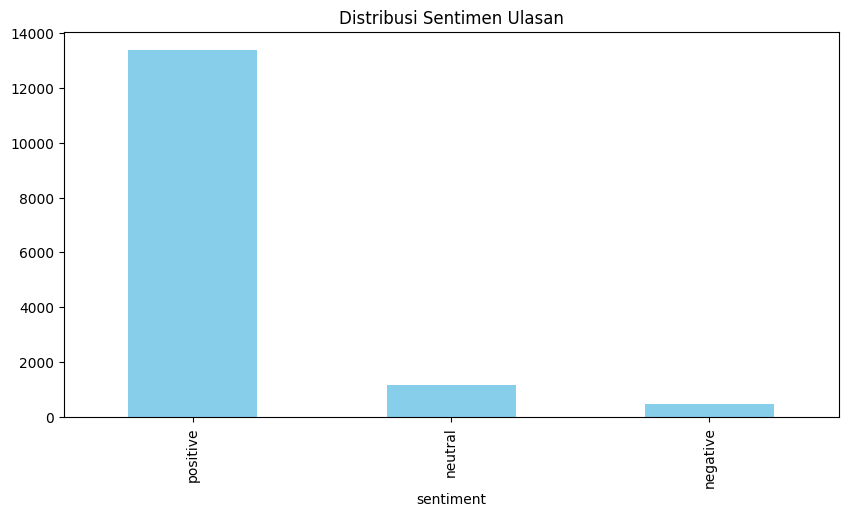

In [840]:
clean_df.sentiment.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Distribusi Sentimen Ulasan')

Text(0.5, 1.0, 'Distribusi Rating Ulasan')

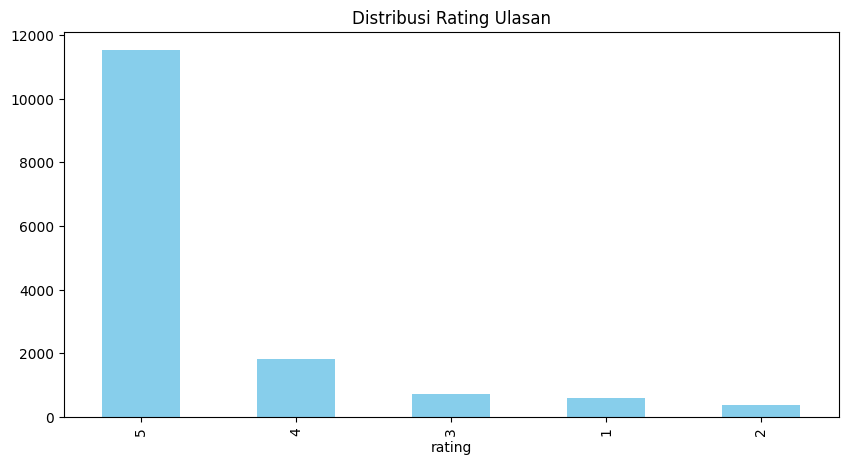

In [841]:
clean_df.rating.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Distribusi Rating Ulasan')

In [842]:
clean_df.head(5)

,review_id,username,rating,date,content,clean_content,sentiment
0,0e5259f4-055a-4548-bc33-75d53b7977fc,Kebasen Jos,3,2025-04-10 12:58:00,apk ini sangat bagus dan membantu untuk belaja...,apk bagus membantu belajar bahasa bintang ikla...,neutral
1,e2f54c77-0551-43e5-aab7-60f5cb953713,Andara Putri,4,2025-04-04 05:46:54,untuk aplikasi nya seruu dan muda untuk di pah...,aplikasi nya seruu muda memahami pengisian cuo...,positive
2,798d3a62-9737-4161-95ef-d5d14155fcc7,Ilyas Al Rizki Muharom,1,2025-03-29 17:50:52,"Untuk aplikasi nya sangat bagus, metode pelaja...",aplikasi nya bagus metode pelajaran nya menari...,neutral
3,d140767b-1c9a-41e6-8612-9b697fbf3e01,Fransiska Langoday,5,2025-03-23 20:31:14,sebelumnya cukup sulit untuk mengumpulkan 5 He...,sulit mengumpulkan heart mentok iklan heart ja...,positive
4,558f02c7-4fa5-4086-b70d-4513b23bc989,Nur Fuadatul,3,2025-04-05 12:42:35,"Duolingo memang baguss polll, aku suka banget....",duolingo baguss polll suka banget akhir² iklan...,neutral


In [895]:
# Pisahkan data menjadi fitur (ulasan) dan label (sentimen)
X = clean_df['clean_content']
y = pd.get_dummies(clean_df['sentiment']).values

In [897]:
# Fungsi untuk evaluasi model
def evaluate_deep_model(model, X_train, X_test, y_train, y_test, epochs=50, batch_size=32):
    # Callback
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=2,
        restore_best_weights=True,
        min_delta=0.001
    )    

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Evaluasi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Convert predictions from probabilities to class indices
    y_pred_train_classes = np.argmax(y_pred_train, axis=1)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)
    
    # Convert true labels from one-hot to class indices
    y_train_classes = np.argmax(y_train, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    print("\nTraining Accuracy:", accuracy_score(y_train_classes, y_pred_train_classes))
    print("Testing Accuracy:", accuracy_score(y_test_classes, y_pred_test_classes))
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_test_classes, target_names=clean_df.sentiment.unique()))
    
    return model, history

### Percobaan 1
Ekstraksi fitur: Word Embedding (Word2Vec) <br>
Pembagian data: 80/20 <br>
Model: Long Short - Term Memory (LSTM)

In [ ]:
tokenized_data = [word_tokenize(sentence.lower()) for sentence in X]

In [ ]:
# Latih Word2Vec
model = Word2Vec(sentences=tokenized_data, vector_size=128, window=5, min_count=1, workers=4)

In [ ]:
# Konversi teks ke indeks berdasarkan Word2Vec vocabulary
word2idx = {word: idx for idx, word in enumerate(model.wv.index_to_key)}
sequences = [[word2idx[word] for word in sent if word in word2idx] for sent in tokenized_data]

# Padding sequences
max_len = 100
X1 = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Split data 80/20
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42)

In [ ]:
# Buat embedding matrix
vocab_size = len(model.wv.index_to_key)
embedding_dim = 128  # Sesuai dengan vector_size Word2Vec

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for idx, word in enumerate(model.wv.index_to_key):
    embedding_matrix[idx] = model.wv[word]

In [ ]:
# bangun model LSTM
lstm_model = Sequential([
    # Gunakan embedding matrix dari Word2Vec
    Input(shape=(max_len,)),  # Layer input
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_len, 
              trainable=False),  
    
    # Layer LSTM
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    
    # Output layer
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas: positive, neutral, negative
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 100, 128)       │     1,138,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,651 (5.05 MB)

 Trainable params: 185,347 (724.01 KB)

 Non-trainable params: 1,138,304 (4.34 MB)

In [ ]:
# Latih model
lstm_model, lstm_history = evaluate_deep_model(lstm_model, X_train1, X_test1, y_train1, y_test1)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7814 - loss: 0.6493 - val_accuracy: 0.8280 - val_loss: 0.4720
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8246 - loss: 0.4817 - val_accuracy: 0.8507 - val_loss: 0.4118
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8375 - loss: 0.4484 - val_accuracy: 0.8553 - val_loss: 0.3884
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8434 - loss: 0.4281 - val_accuracy: 0.8587 - val_loss: 0.3779
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8467 - loss: 0.4201 - val_accuracy: 0.8613 - val_loss: 0.3697
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8488 - loss: 0.4130 - val_accuracy: 0.8620 - val_loss: 0.3674
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.8564 - loss: 0.4032 - val_accuracy: 0.8640 - val_loss: 0.3618
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8563 - loss: 0.4044 - 

### Percobaan 2
Ekstraksi fitur: Word Embedding (Word2Vec) <br>
Pembagian data: 90/10 <br>
Model: Bidirectional Long Short - Term Memory (BiLSTM)

In [628]:
# Split data 90/10
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
# Bangun model BiLSTM
bilstm_model = Sequential([
    # Gunakan embedding matrix dari Word2Vec
    Input(shape=(max_len,)),  # Layer input
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_len, 
              trainable=False),  
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

bilstm_model.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

bilstm_model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 100, 128)       │     1,138,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 100, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,979 (4.88 MB)

 Trainable params: 140,675 (549.51 KB)

 Non-trainable params: 1,138,304 (4.34 MB)

In [ ]:
# Latih model
bilstm_model, bilstm_history = evaluate_deep_model(bilstm_model, X_train2, X_test2, y_train2, y_test2)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.7911 - loss: 0.6241 - val_accuracy: 0.8020 - val_loss: 0.5621
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.8024 - loss: 0.5641 - val_accuracy: 0.7993 - val_loss: 0.5365
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.8057 - loss: 0.5471 - val_accuracy: 0.8093 - val_loss: 0.5085
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.8072 - loss: 0.5139 - val_accuracy: 0.8153 - val_loss: 0.4988
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.8139 - loss: 0.5029 - val_accuracy: 0.8153 - val_loss: 0.4918
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.8202 - loss: 0.4791 - val_accuracy: 0.8153 - val_loss: 0.4771
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.8251 - loss: 0.4709 - val_accuracy: 0.8153 - val_loss: 0.4685
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8275 - loss: 0.4634 - 

### Percobaan 3
Ekstraksi fitur: TF-IDF <br>
Pembagian data: 80/20 <br>
Model: Multi Layer Perceptron (MLP)

In [898]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X3 = tfidf.fit_transform(X)

In [899]:
# Split data 80/20
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=42)

In [902]:
mlp_model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train3.shape[1],)),
    BatchNormalization(),
    Dropout(0.3, seed=SEED),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3, seed=SEED),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=2, 
    min_lr=1e-6
)

mlp_model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1024)           │     5,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,785,091 (22.07 MB)

 Trainable params: 5,781,507 (22.05 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [903]:
# Latih model
mlp_model, mlp_history = evaluate_deep_model(mlp_model, X_train3, X_test3, y_train3, y_test3)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.6899 - loss: 7.7414 - val_accuracy: 0.8907 - val_loss: 1.8212
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9098 - loss: 1.1950 - val_accuracy: 0.8917 - val_loss: 0.6908
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9449 - loss: 0.4271 - val_accuracy: 0.8643 - val_loss: 0.6438
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Training Accuracy: 0.8920833333333333
Testing Accuracy: 0.8906666666666667

Classification Report:
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       109
    positive       0.00      0.00      0.00       219
    negative       0.89      1.00      0.94      2672

    accuracy                           0.89      3000
   macro avg       0.30      0.33      0.31      3000
weighted avg       0.79      0.89      0.84      3000

